# Synthesis with a configuration file

Perhaps the simplest approach to Hazel is to use configuration files. In this notebook we show how to use a configuration file to run Hazel in different situations.

## Single pixel synthesis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

/scratch/Dropbox/GIT/hazel2/hazel/io.py:12: UserWarning: zarr module not found. You will not be able to use zarr as input/output.
  warnings.warn("zarr module not found. You will not be able to use zarr as input/output.")


2018.06.07


Configuration files can be used very simply by just instantiating the `Model` with a configuration file. First, let's print the configuration file. The architecture of the file is explained in the documentation.

In [2]:
%cat conf_single.ini

# Hazel configuration File

[Working mode]
Output file = output.zarr
Number of cycles = 1

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Wavelength = 10826, 10833, 150
    Topology = ph1 -> ch1 -> te1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = 'observations/10830.wavelength'
    Wavelength weight file = 'observations/10830.weights'
    Observations file = 'observations/10830_stokes.1d'    
    Weights Stokes I = 1.0, 0.0, 0.0, 0.0
    Weights Stokes Q = 0.0, 0.0, 0.0, 0.0
    Weights Stokes U = 0.0, 0.0, 0.0, 0.0
    Weights Stokes V = 0.0, 0.0, 0.0, 0.0
    Ma

We use this file and do the synthesis.

In [6]:
mod = hazel.Model('../configuration/conf_single.ini', working_mode='synthesis', verbose=3)
mod.synthesize()

2018-10-01 09:27:12,235 - Adding spectral region spec1
2018-10-01 09:27:12,235 -   - Reading wavelength axis from ../observations/10830.wavelength
2018-10-01 09:27:12,238 -   - Reading wavelength weights from ../observations/10830.weights
2018-10-01 09:27:12,244 -   - Using observations from ../observations/10830_stokes.1d
2018-10-01 09:27:12,245 -   - No mask for pixels
2018-10-01 09:27:12,246 -   - No instrumental profile
2018-10-01 09:27:12,247 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-01 09:27:12,249 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-01 09:27:12,250 - Not using randomizations
2018-10-01 09:27:12,252 - Adding atmospheres
2018-10-01 09:27:12,257 -   - New available photosphere : ph1
2018-10-01 09:27:12,269 -     * Adding line : [300]
2018-10-01 09:27:12,270 -     * Magnetic field reference frame : vertical
2018-10-01 09:27:12,272 -     * Reading 1D model ../models/photospheres/model_photosphere_200.1d as reference
2018-10-01 09:27:12,276 -   - N

And now do some plots.

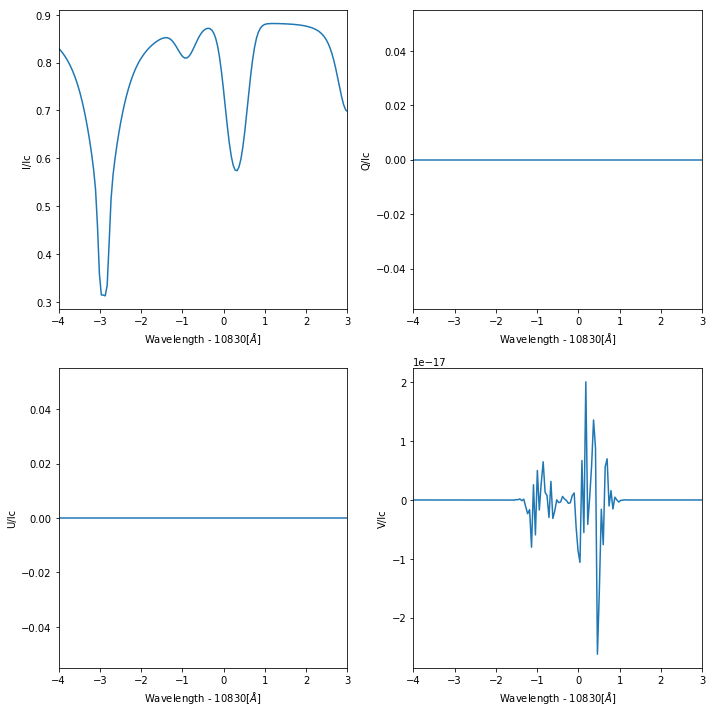

In [7]:
f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(mod.spectrum['spec1'].wavelength_axis - 10830, mod.spectrum['spec1'].stokes[i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-4,3])
    
pl.tight_layout()

It is possible to save the output of a single pixel to a file. In this case, just open the file, do the synthesis, write to the file and close it.

In [8]:
mod = hazel.Model('../configuration/conf_single.ini', working_mode='synthesis')
mod.open_output()
mod.synthesize()
mod.write_output()
mod.close_output()

The output file contains a dataset for the currently synthesized spectral region. Here you can see the datasets and their content:

In [11]:
f = h5py.File('output.h5', 'r')
print(list(f.keys()))
print(list(f['spec1'].keys()))
f['spec1']['stokes'].shape

['spec1']
['stokes', 'wavelength']


(1, 1, 1, 4, 150)

And then we do some plots:

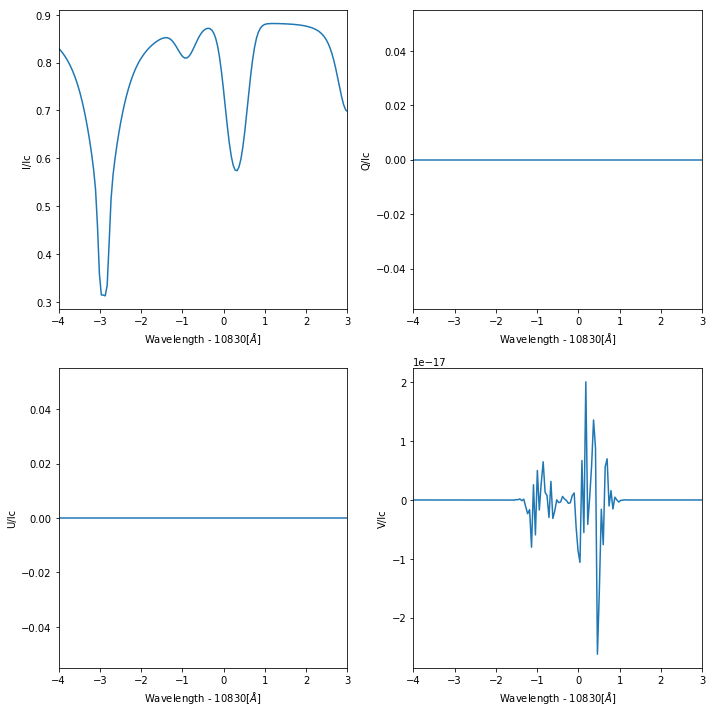

In [12]:
fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,0,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-4,3])
    
pl.tight_layout()

f.close()

## Many pixels synthesis
Synthesizing many pixels can be exhausting and time consuming if you do it one by one. For this reason, Hazel can admit HDF5 files with different models for the synthesis.

### Without MPI
The simplest option is to iterate over all pixels with a single CPU. To this end, we make use of the `iterator`. You first instantiate the iterator and then pass the model to the iterator, which will take care of iterating through all pixels.

In [14]:
iterator = hazel.Iterator(use_mpi=False)
rank = iterator.get_rank()
mod = hazel.Model('../configuration/conf_nonmpi_syn1d.ini', working_mode='synthesis', verbose=2)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2018-10-01 09:31:39,263 - Adding spectral region spec1
2018-10-01 09:31:39,265 -   - Reading wavelength axis from ../observations/10830.wavelength
2018-10-01 09:31:39,268 -   - Reading wavelength weights from ../observations/10830.weights
2018-10-01 09:31:39,273 -   - Using observations from ../observations/10830_stokes.1d
2018-10-01 09:31:39,274 -   - No mask for pixels
2018-10-01 09:31:39,275 -   - No instrumental profile
2018-10-01 09:31:39,276 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-01 09:31:39,277 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-01 09:31:39,279 - Not using randomizations
2018-10-01 09:31:39,281 - Adding atmospheres
2018-10-01 09:31:39,282 -   - New available photosphere : ph1
2018-10-01 09:31:39,283 -     * Adding line : [300]
2018-10-01 09:31:39,285 -     * Magnetic field reference frame : vertical
2018-10-01 09:31:39,286 -     * Reading 3D model ../models/photospheres/model_photosphere.h5 as reference
2018-10-01 09:31:39,295 -   - New a

(npix,nrandom,ncycle,nstokes,nlambda) -> (2, 1, 1, 4, 150)


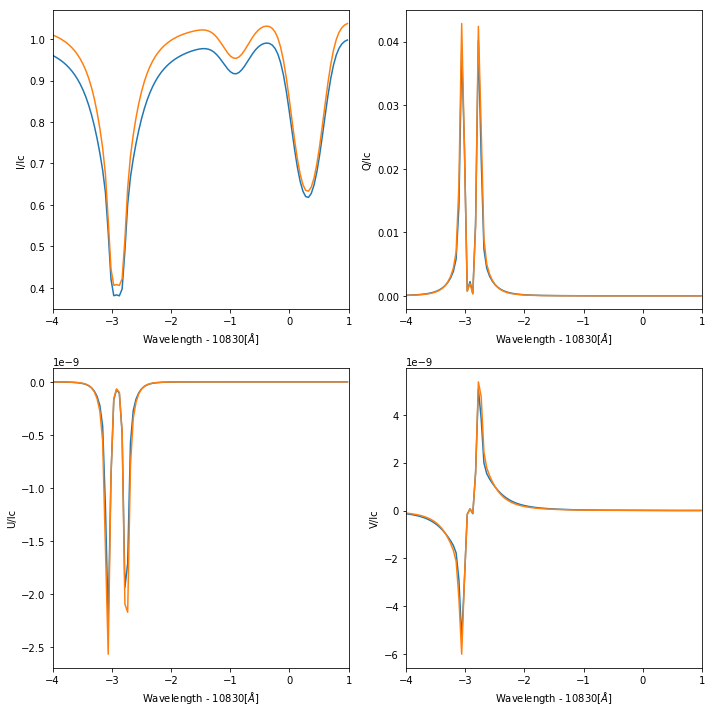

In [16]:
f = h5py.File('output.h5', 'r')

print('(npix,nrandom,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for j in range(2):
    for i in range(4):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][j,0,0,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-4,1])
    
pl.tight_layout()

f.close()

### With MPI
In case you want to synthesize large maps in a supercomputer, you can use `mpi4py` and run many pixels in parallel. To this end, you pass the `use_mpi=True` keyword to the iterator. Then, this piece of code should be called with `mpiexec` to run it using MPI:

`mpiexec -n 10 python code.py`

In [ ]:
iterator = hazel.iterator(use_mpi=True)
rank = iterator.get_rank()
mod = hazel.Model('conf_mpi_synh5.ini', working_mode='synthesis', rank=rank)
iterator.use_model(model=mod)
iterator.run_all_pixels()